# Skew Correction

This google colab notebook introduces basic Document Image Processing Method called **Skew Correction**. 

Skew refers to the rotation of a document image from its intended orientation. This can happen during the scanning process and can affect the readability and usability of the document image.

---

Use the following drive link to access the images.

Drive Link: https://drive.google.com/drive/folders/1ivc4ISlTaUerNKcrMZUIb1yU-wkDZW-Y


## Mounting the google drive and loading requried libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import numpy as np
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.transform import rotate
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy.stats import mode
import cv2
from google.colab.patches import cv2_imshow

## 1. Skew Detection: 3 Steps

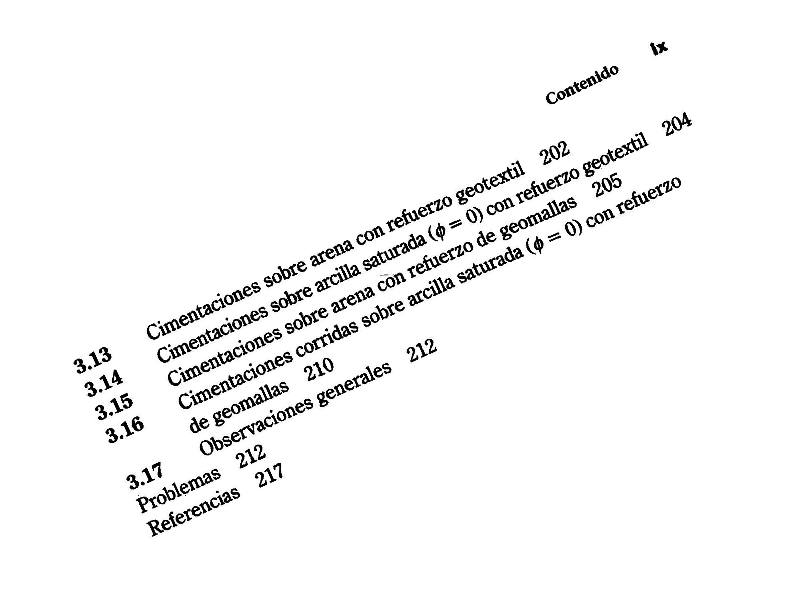

In [5]:
#@title Read Images
# reading Images 
path = 'drive/MyDrive/skew/easy/1.png'
image  = imread(path)
cv2_imshow(image)

Convert to Grayscale

In [6]:
print(image.shape)
# gray = rgb2gray(image)
# cv2_imshow(gray)

(600, 800)


Why the **3** in `image[:,:,:3]`?

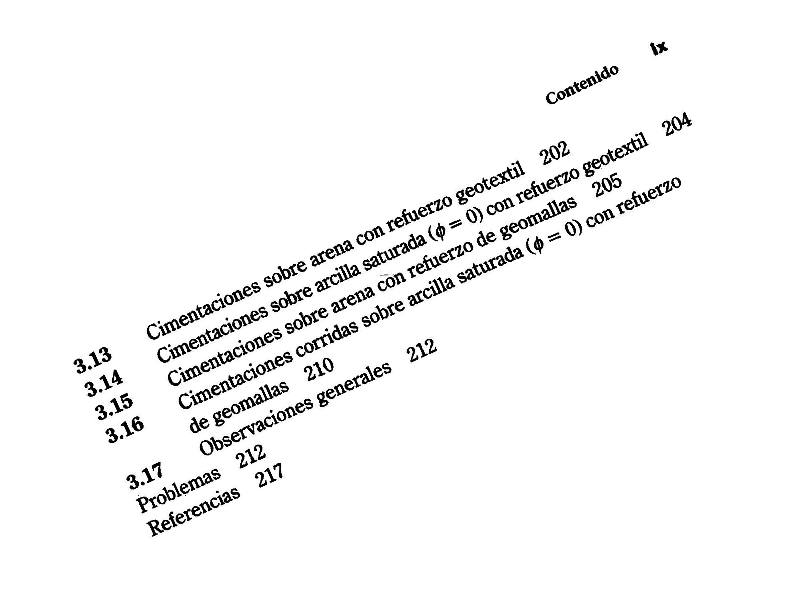

In [7]:
#@title Solution
if len(image.shape)>2:
  gray = rgb2gray(image[:,:,:3])
else:
  gray = image

cv2_imshow(gray)

#### Step-1: Edge Detection - `Canny` 

- Recall Yesterday's Sobel Filters!
- Canny Edge Detection is Similar with Extra Preprocessing and Refinement Steps like: Noise Reduction, Non-Maximal Supression, etc. 

Reference: 
1. https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html
2. https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny


Function Signature: `canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False, *, mode='constant', cval=0.0)`

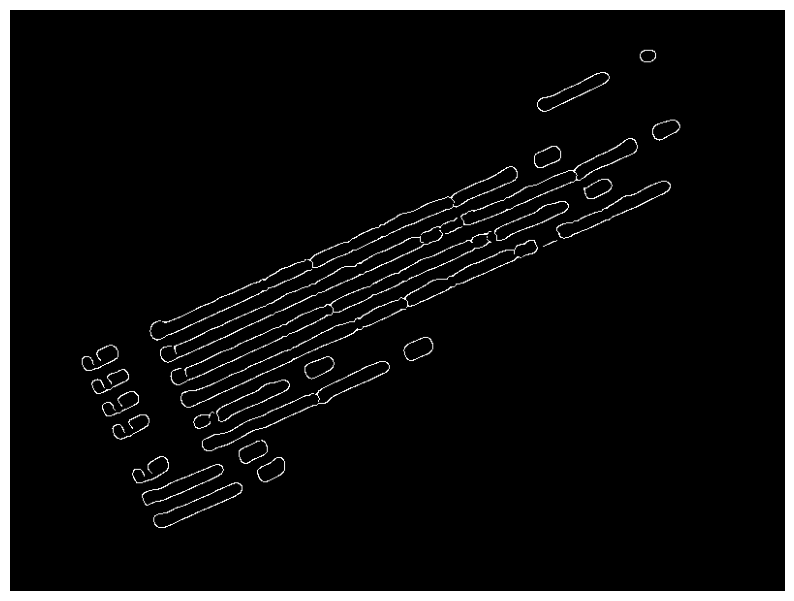

In [8]:
# edge detection
edges = canny(gray, sigma=5)

# edges = canny(gray, sigma=0.5) # for lines detection 
# edges = canny(gray, sigma=10) # all black
# edges = canny(gray, sigma=0.0000001) # too much noise

# edges = canny(gray, low_threshold= 20, high_threshold=10)  ---> low_threshold should be lower then high_threshold
              

plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(edges, cmap='gray')

### Step-2: Line Detection - `Hough Transform`

Reference: https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

Define Range of Angles

In [9]:
# define range of angles
angles = np.deg2rad(np.arange(0.1, 180.0)) # they will be in radian
# print(angles)
print('Count: ',len(angles))
# print(angles)

Count:  180


Use `hough_line(edges, theta=angles)` from skimage

Returns:
- `hspace`: is a 2D array that represents the Hough accumulator. The Hough accumulator is a data structure that is used to store the number of times each possible line is detected in the image.
- `theta`: is a 1D array that represents the angles of the detected lines. The angles are measured in radians.
- `distance`: is a 1D array that represents the distances of the detected lines from the origin. The distances are measured in pixels.

(2001,)
(180,)
(2001, 180)


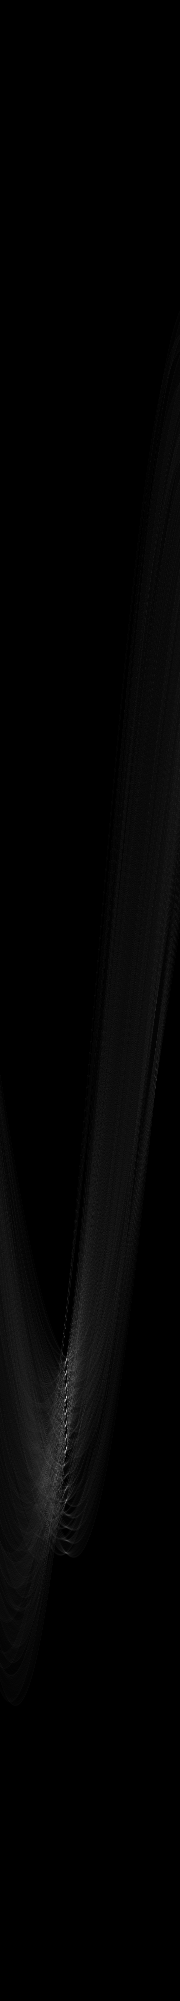

In [10]:
h, theta, d = hough_line(edges, theta=angles) # since we need 3 paramters to define a lot of shapes
# edges = all the pixels where the values are 1
# thetha : angle/slope
# d : distance
# h : vote (accumulator) - the confidence ( if for a thetha and d (a line is defined)) to for an r and thetha then the vote/confidence will increase [BY FIRST SHIFTING INTO HOUGH SPACE (else it would become 180*num(pixels) in the normal cartesian place)]


print(d.shape) # 2001 (maximum r which is possible)
print(theta.shape) # 180
print(h.shape)  # 2001*180

cv2_imshow(h)

**Get Prominent Lines**: `hough_line_peaks`

Function Signature: `hough_line_peaks(hspace, angles, dists, min_distance=9, min_angle=10, threshold=None, num_peaks=inf)`

- Most prominent lines separated by a certain angle and distance in a Hough transform.
- Performs [Non-maximum Suppression](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) to identify Peaks

In [11]:
# find line peaks and angles
accum, angles, dists = hough_line_peaks(h, theta, d)

# min_distance = remove the lines which have similar angle and have a distance of less than 9
# min_distance = remove the lines which have similar distance and have an angle difference of less than 10

In [12]:
list(zip(*hough_line_peaks(h, theta, d)))


# print(h.max())

[(220, 1.1536626355682518, 397.0),
 (203, 1.1536626355682518, 447.0),
 (198, 1.1362093430483085, 425.0),
 (195, 1.1362093430483085, 374.0),
 (180, 1.1536626355682518, 385.0),
 (172, 1.1536626355682518, 410.0),
 (172, 1.1536626355682518, 359.0),
 (152, 1.1536626355682518, 435.0),
 (128, 1.1536626355682518, 500.0)]

##### Visualize Detected Lines

Text(0.5, 1.0, 'Detected lines')

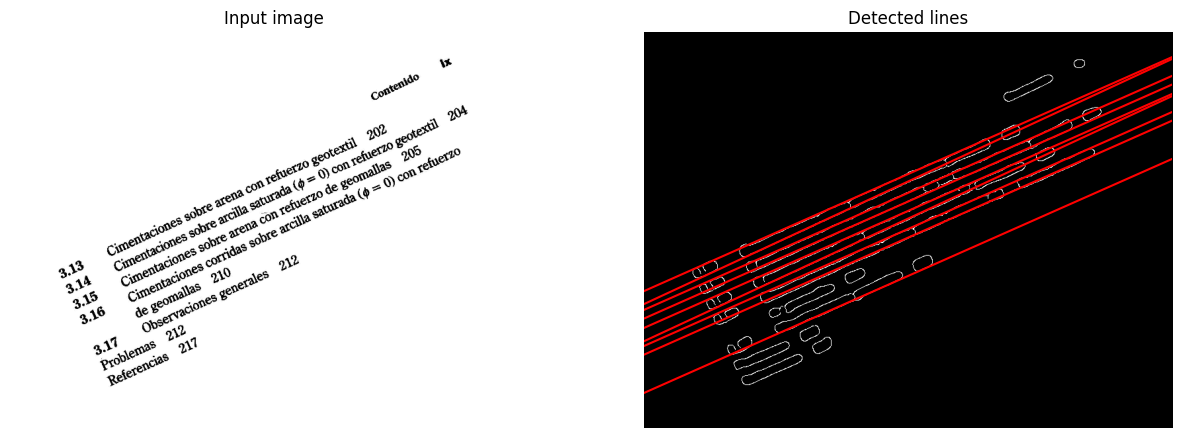

In [13]:
# Generating Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(gray, cmap="gray")
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap="gray")
origin = np.array((0, image.shape[1]))

# plot lines
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r')
    
ax[1].set_xlim(origin)
ax[1].set_ylim((edges.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')

In [14]:
# Try Faster Houghline!
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

### Step-3: Domninant Angle - Most Common Angle

##### Visualize Hough Space

(-0.4, 179.6, 1000.5, -1000.5)

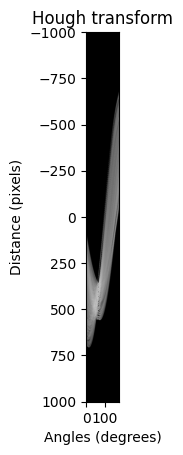

In [15]:
# Visualize Hough Space

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.imshow(np.log(1 + h), extent=bounds, cmap='gray', aspect=1 / 1.5)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.axis('image')



```
# This is formatted as code
```

##### Mode - Common  (most occuring)

In [16]:
# round the angles to 2 decimal places and find the most common angle.
dominant_angle = mode(np.around(angles, decimals=3), keepdims=False)[0]
dominant_angle

1.154

In [17]:
# convert the angle to degree for rotation.
skew_angle = np.rad2deg(dominant_angle - np.pi/2)
skew_angle

-23.880670441903003

Why did we subtract $\frac{Π}{2}$?


To converting the orientation from one axis (x-axis which was given by Hough Transform) to another axis (y -axis ,  which we will require for the transformation)

Try without Subtracting!

In [18]:
angle_ = np.rad2deg(dominant_angle)
angle

1.1536626355682518

## 2. Skew Correction: Rotate the image to deskew it

### Finaly There!! Get the rotated Image Back! Easy

![](https://media.tenor.com/PriVq8YusysAAAAM/yeah-but-how-stan-marsh.gif)


### Apply Affine Transform!

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--_L7TDW3Y--/c_imagga_scale,f_auto,fl_progressive,h_900,q_auto,w_1600/https://dev-to-uploads.s3.amazonaws.com/i/yhc6kp16j6bi5ddtfn88.png" alt= “Affine” width="60%" height="value">

What is an Affine Transformation?
- A transformation: a matrix multiplication (linear transformation) followed by a vector addition (translation).
- Parallel Line remain parallel after Transform

We can express following with Affine:
- Rotations (linear transformation)
- Translations (vector addition)
- Scale operations (linear transformation)

Resource: https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html

How do we rotate?
$$
R = \begin{bmatrix}
α & β & (1−α)⋅center.x−β⋅center.y \\
-β & α & β⋅center.x+(1−α)⋅center.y
\end{bmatrix}
$$
![](https://i.imgflip.com/11dmtp.jpg)
![opencv](https://github.com/mhardik003/CVIT-Workshop/blob/main/Day%202/Session%201/Task%201/7mr495.jpg?raw=1)

Function: `cv2.getRotationMatrix2D(center, angle, scale)`

Paramters:
- `center`:	Center of the rotation in the source image.
- `angle`:	Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
- `scale`:	Isotropic scale factor.

Find Centre

In [19]:
# find center
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

print(center)

(400, 300)


Get Rotation Matrix, $R$

Reference: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326

In [20]:
R = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
R # scale, transformation and rotation

array([[   0.91439058,   -0.40483313,  155.69370466],
       [   0.40483313,    0.91439058, -136.25042586]])

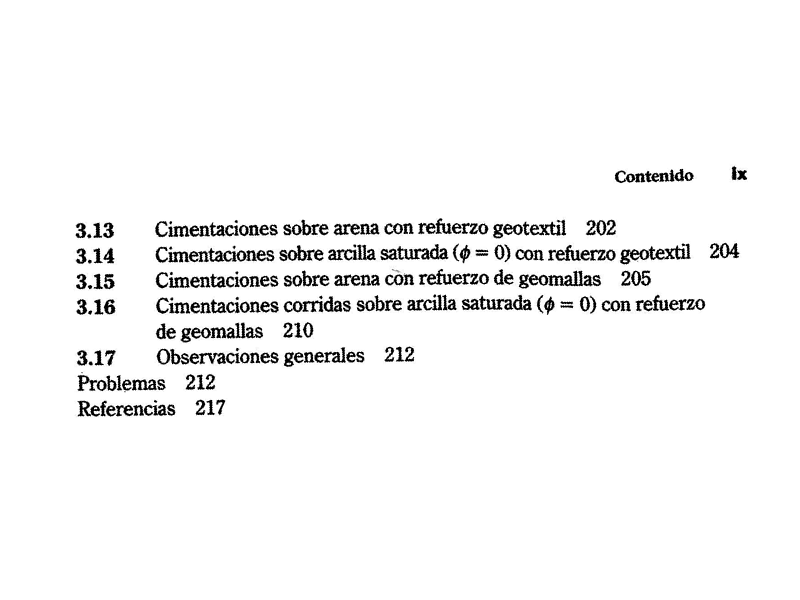

In [21]:
rotated = cv2.warpAffine(image, R, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
cv2_imshow(rotated)

Another Way!

Rotate Fn Signature: `rotate(image, angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)`

Reference: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rotate

In [22]:
# !pip install -U scikit-image

In [31]:
# rotated_faulty = rotate(image, skew_angle, resize=False, center=None, order=None, mode='constant', cval=0, clip=True, preserve_range=False)
rotated_faulty = rotate(image, skew_angle, resize=False, center=None, order=None, mode='edge', cval=0, clip=True, preserve_range=False)

# from skimage.util import pad
# top_pad = 10
# bottom_pad = 10
# left_pad = 10
# right_pad = 10

# Pad the image using replicate border mode
# rotated_faulty = pad(rotated_faulty, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='edge')


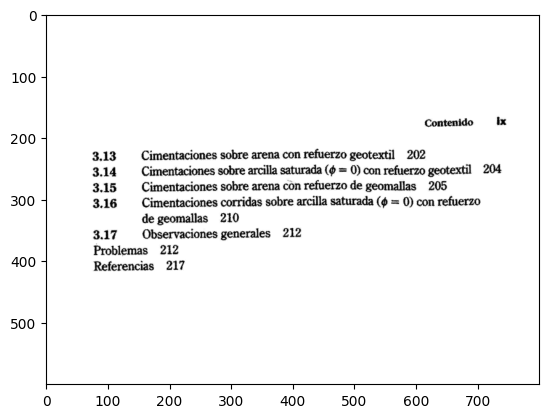

In [32]:
plt.imshow(rotated_faulty, cmap='gray')

Issues:
1. Colour: Black Region
2. Boundaries

Fix it!

#### Skew Correction: Final Function 

In [43]:
# skew detecttion
def detect_skew(img:np.ndarray)->float:
  # ADD Your Code Here
  pass

# rotate Image
def deSkew(skew_angle:float)->np.ndarray:
  # ADD Your Code Here
  pass

def post_processing(rotated: np.ndarray)->np.ndarray:
  # Hint: The images don't look crisp! And the borders seem visible
  # ADD Your Code Here
  pass

def SkewCorrection(path, verbose=False):
  # read Image
  # ADD Your Code Here
  
  # determine angle
  skew_angle = detect_skew(image)
  
  if verbose:
    print(f'Skew Angle is {skew_angle:.3f}')

  # Rotate Image
  rotated = deSkew(image)

  # post processing!
  rotated_final = post_processing(rotated)
  
  # plot images

  return rotated_final

In [44]:
def plot_images(image, rotated):
  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  ax = axes.ravel()

  ax[0].imshow(image, cmap="gray")
  ax[0].set_title('Input image')
  ax[0].set_axis_off()

  ax[1].imshow(rotated, cmap="gray")
  ax[1].set_axis_off()
  ax[1].set_title('Skew Corrected')

  return

def show_detected_lines(image, edges, lines):
  # Generating Plots
  fig, axes = plt.subplots(1, 2, figsize=(15, 15))
  
  # fig.suptitle('Intermediate Lines')
  
  ax = axes.ravel()

  ax[0].imshow(image, cmap="gray")
  ax[0].set_title('Input image')
  ax[0].set_axis_off()

  ax[1].imshow(edges, cmap="gray")
  origin = np.array((0, image.shape[1]))

  # plot lines
  for _, angle, dist in lines:
      y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
      ax[1].plot(origin, (y0, y1), '-r')
      
  ax[1].set_xlim(origin)
  ax[1].set_ylim((edges.shape[0], 0))
  ax[1].set_axis_off()
  ax[1].set_title('Detected lines')

  return

In [45]:
#@title Final Algorithm

# skew detecttion
def detect_skew(image:np.ndarray, show_interm=False)->float:
  # convert to edges
  edges = canny(image)
  # Classic straight-line Hough transform between 0.1 - 180 degrees.
  angles = np.deg2rad(np.arange(0.1, 180.0))
  h, theta, d = hough_line(edges, theta=angles)
  
  # find line peaks and angles
  accum, angles, dists = hough_line_peaks(h, theta, d)
  lines = zip(accum, angles, dists)

  if show_interm:
    show_detected_lines(image, edges, lines)
  
  # round the angles to 3 decimal places and find the most common angle.
  dominant_angle = mode(np.around(angles, decimals=3), keepdims=False)[0]
  
  # convert the angle to degree for rotation.
  skew_angle = np.rad2deg(dominant_angle - np.pi/2)

  return skew_angle

def preprocessing(image:np.ndarray, noprep=True):
  if len(image.shape)>2:
    image = rgb2gray(image[:,:,:3])

  if not noprep:
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    # Apply image denoising
    denoised = cv2.fastNlMeansDenoising(blur, None, h=10, templateWindowSize=7, searchWindowSize=21)
      
    # Apply binary thresholding
    _, binary = cv2.threshold(denoised, 127, 255, cv2.THRESH_BINARY)

    return binary
  else:
    return image

# rotate Image
def deSkew(image:np.ndarray, skew_angle:float)->np.ndarray:
  '''rotate the image to deskew it'''
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  
  R = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
  rotated = cv2.warpAffine(image, R, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

  return rotated

def post_processing(rotated: np.ndarray)->np.ndarray:
  # Hint: The images don't look crisp!
  pass
  return rotated

def SkewCorrection(path, verbose=False, noprep=True):
  # read Image
  image = imread(path)

  image_pre = preprocessing(image, noprep)

  if not noprep:  
    plt.title('After Preprocessing')
    plt.imshow(image_pre, cmap='gray')

  # determine angle
  skew_angle = detect_skew(image_pre, verbose)

  # print('\n\n\n')

  # if verbose:
  #   print(f'Skew Angle is {skew_angle:.3f}')
  
  # if skew_angle < -45:
  #   skew_angle = -(90 + skew_angle)
  # # otherwise, just take the inverse of the angle to make
  # # it positive
  # else:
  #   skew_angle = skew_angle
  
  if verbose:
    print(f'Skew Angle is {skew_angle:.3f}')

  # Rotate Image
  rotated = deSkew(image, skew_angle)

  # post processing!
  rotated_final = post_processing(rotated)
  
  print('\n\n\n')
  
  # plot images
  plot_images(image, rotated_final)


  return rotated_final

In [46]:
deSkewed_img = SkewCorrection('/content/skew/easy/1.png', verbose=True)

FileNotFoundError: ignored

In [47]:
deSkewed_img = SkewCorrection('/content/skew/easy/7.png', verbose=True)

FileNotFoundError: ignored

In [ ]:
deSkewed_img = SkewCorrection('/content/skew/easy/8.png', verbose=True)

In [48]:
deSkewed_img = SkewCorrection('/content/skew/easy/9.png', verbose=True)

FileNotFoundError: ignored

In [ ]:
deSkewed_img = SkewCorrection('/content/skew/hard/5.png', verbose=True)

In [49]:
deSkewed_img = SkewCorrection('/content/skew/med/1_pn.png', verbose=True)

FileNotFoundError: ignored

In [ ]:
deSkewed_img = SkewCorrection('/content/skew/med/1_s.png', verbose=True)

There is no One-size-fits-all solution!!
- Possible solutions: Compute the minimum rotated bounding Bounding Rectangle.